In [1]:
import pandas as pd
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load keyword extraction test dataset
keyphrase_test_dataset = load_dataset("midas/inspec", split="validation", trust_remote_code=True)

# Load the custom models
keyphrase_model_name = "ml6team/keyphrase-extraction-distilbert-inspec"
keyphrase_tokenizer = AutoTokenizer.from_pretrained(keyphrase_model_name)
keyphrase_model = AutoModelForTokenClassification.from_pretrained(keyphrase_model_name)
keyphrase_pipeline = pipeline("ner", model=keyphrase_model, tokenizer=keyphrase_tokenizer, aggregation_strategy="simple")

Repo card metadata block was not found. Setting CardData to empty.
d:\AmritaUniversity\AmmachiLabs\CapacityBuildingPortal\flask-backend\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# Function to preprocess and normalize keyphrases
def preprocess_keyphrases(tokens, tags):
    keyphrases = []
    current_phrase = []
    for token, tag in zip(tokens, tags):
        if tag == 'B':
            if current_phrase:
                keyphrases.append(' '.join(current_phrase))
                current_phrase = []
            current_phrase.append(token)
        elif tag == 'I':
            if current_phrase:
                current_phrase.append(token)
        elif tag == 'O' and current_phrase:
            keyphrases.append(' '.join(current_phrase))
            current_phrase = []
    if current_phrase:
        keyphrases.append(' '.join(current_phrase))
    return set(map(lambda x: x.lower().strip(), keyphrases))

In [4]:
# Function to extract keyphrases
def extract_keyphrases(text):
    results = keyphrase_pipeline(text)
    keyphrases = set([result['word'].strip().lower() for result in results])
    return keyphrases

In [5]:
# Normalize and calculate overlap metrics
def normalize_keyphrases(keyphrases):
    return set(map(lambda x: x.lower().strip(), keyphrases))

In [6]:
# Evaluate Keyphrase Extraction
true_keyphrases_all = []
predicted_keyphrases_all = []

In [7]:
print("Debugging: Comparing True and Predicted Keyphrases")
for i, example in enumerate(keyphrase_test_dataset):
    text = " ".join(example['document'])  # Join tokens to form the document text
    true_keyphrases = preprocess_keyphrases(example['document'], example['doc_bio_tags'])  # Extract true keyphrases
    predicted_keyphrases = extract_keyphrases(text)
    
    true_keyphrases_all.append(true_keyphrases)
    predicted_keyphrases_all.append(predicted_keyphrases)

Debugging: Comparing True and Predicted Keyphrases


In [8]:
# Flatten lists of sets for precision, recall, and F1-score calculation
true_keyphrases_flat = [item for sublist in true_keyphrases_all for item in sublist]
predicted_keyphrases_flat = [item for sublist in predicted_keyphrases_all for item in sublist]

print(f"Length of true keyphrases (flat): {len(true_keyphrases_flat)}")
print(f"Length of predicted keyphrases (flat): {len(predicted_keyphrases_flat)}")

Length of true keyphrases (flat): 2978
Length of predicted keyphrases (flat): 4234


In [9]:
# Calculate precision, recall, and F1-score for partial matches
def partial_match_score(true, pred):
    total_matches = 0
    for t in true:
        for p in pred:
            if t in p or p in t:
                total_matches += 1
                break
    return total_matches

In [20]:
true_matches = partial_match_score(true_keyphrases_flat, predicted_keyphrases_flat)
pred_matches = partial_match_score(predicted_keyphrases_flat, true_keyphrases_flat)

precision = true_matches / len(predicted_keyphrases_flat)
recall = true_matches / len(true_keyphrases_flat)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Keyphrase Extraction - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Keyphrase Extraction - Precision: 0.6963, Recall: 0.9899, F1-Score: 0.8175


C:\Users\User\AppData\Local\Temp\ipykernel_30888\3534203378.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Metric', y='Score', data=data, palette=colors)


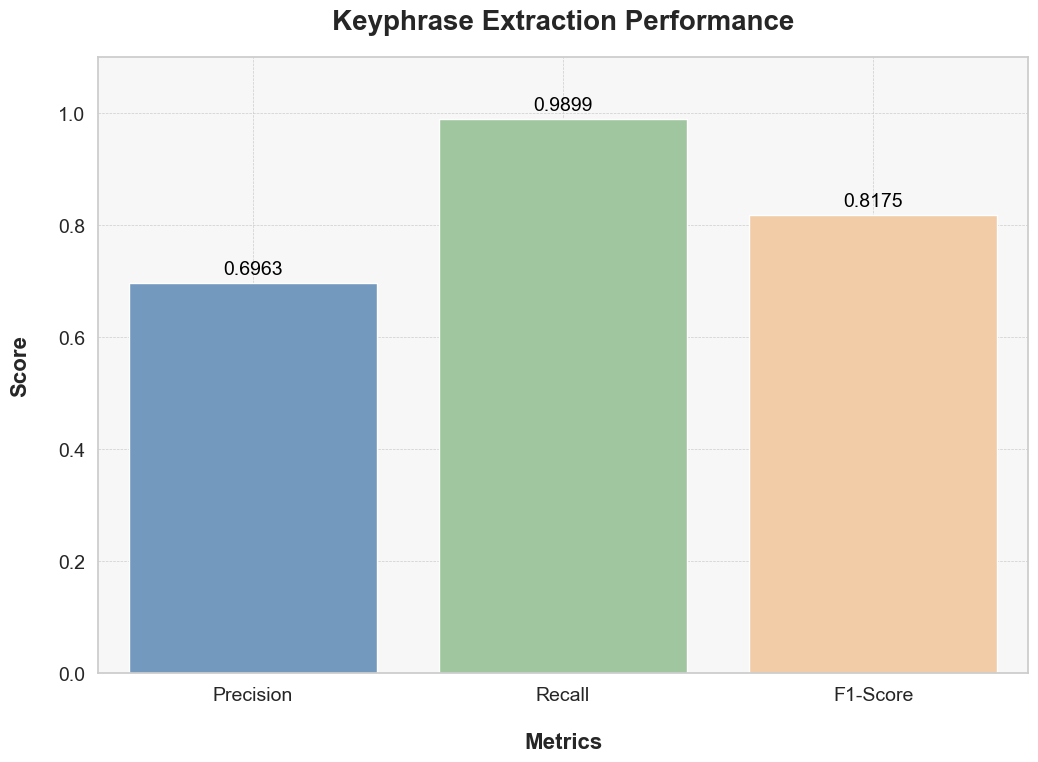

In [21]:
# Data for plotting
metrics = ['Precision', 'Recall', 'F1-Score']
scores = [precision, recall, f1]
colors = ['#6699CC', '#99CC99', '#FFCC99']  # Custom colors for the bars

# Set the style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))

# Plot using seaborn for better integration with the DataFrame
data = pd.DataFrame({
    'Metric': metrics,
    'Score': scores
})

# Plot each bar individually with the custom colors
ax = sns.barplot(x='Metric', y='Score', data=data, palette=colors)

# Add annotations
for bar, score in zip(ax.patches, scores):
    ax.annotate(f'{score:.4f}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center', fontsize=14, color='black', xytext=(0, 10),
                textcoords='offset points')

# Set title and labels
plt.title('Keyphrase Extraction Performance', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Metrics', fontsize=16, fontweight='bold', labelpad=20)
plt.ylabel('Score', fontsize=16, fontweight='bold', labelpad=20)
plt.ylim(0, 1.1)

# Customize the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_axisbelow(True)

# Customize tick parameters
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add background color to the plot area
plt.gca().set_facecolor('#f7f7f7')

# Show the plot
plt.show()